In [74]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
df = pd.read_csv('data/data.csv')

/Users/mattkruse/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,handle,user_name,candidate_2020,join_2020,candidate_2016,join_2016,text,created_at
0,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,@Mistirae4 Welcome! 😀👍,2020-05-25 01:17:08
1,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,Congratulations!! 🙏😀❤️,2020-05-25 01:13:31
2,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,RT @AiaAsians: So happy to support #AsianAmeri...,2020-05-25 00:58:07
3,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,@carlo_w22 upstate New York,2020-05-24 23:41:47
4,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,It’s a beautiful country. 👍🇺🇸,2020-05-24 23:22:27


In [4]:
#removing the websites from tweet data
df['text'] = df['text'].str.replace('http\S+|www.\S+', '', case=False)

In [15]:
#2020 candidates with 2018 tweets
tweets_2018 = df[(df['created_at'] >= '2018-01-01') & (df['created_at'] < '2018-12-31')]
candidates_2018 = tweets_2018['handle'].unique()
#2020 candidates w/o 2018 tweets
not_2018 = df[~df.handle.isin(candidates_2018)]
candidates_not2018 = not_2018['handle'].unique()

In [38]:
print("Candidates who tweeted in 2018: ", candidates_2018)
print("Candidates who did not tweet in 2018: ", candidates_not2018)

Candidates who tweeted in 2018:  ['BilldeBlasio' 'BobbyJindal' 'CarlyFiorina' 'CoryBooker' 'DevalPatrick'
 'GovChristie' 'GovMikeHuckabee' 'GovernorBullock' 'GovernorPataki'
 'GovernorPerry' 'Hickenlooper' 'HillaryClinton' 'JebBush' 'JimWebbUSA'
 'JoeSestak' 'JohnKasich' 'JoinRocky' 'LincolnChafee' 'LindseyGrahamSC'
 'MarkSanford' 'MartinOMalley' 'MikeBloomberg' 'RandPaul' 'RealBenCarson'
 'RepTimRyan' 'RickSantorum' 'SenGillibrand' 'TulsiGabbard' 'WayneMessam'
 'ericswalwell' 'gov_gilmore' 'lessig' 'sethmoulton' 'JerryNadler'
 'PramilaJayapal' 'SenSchumer' 'HurdOnTheHill' 'SenatorIsakson'
 'MarkMeadows' 'RepRonEstes' 'JahanaHayesCT' 'georgeallenva' 'SenMarkey'
 'SenatorCollins' 'RepAlGreen' 'SenStabenow' 'RonJohnsonWI'
 'SenatorTester' 'maziehirono' 'PatrickMurphyFL' 'SenToomey'
 'jackiewalorski' 'Liz_Cheney' 'GregAbbott_TX' 'RepThomasMassie'
 'RepDougCollins' 'RepTierney' 'JeffLandry' 'DarrellIssa' 'TedYoho'
 'MattBevin' 'SenShelby' 'katieporteroc' 'Sen_JoeManchin' 'GovHawaii'
 'Mitt

Median Tweets for Candidates:  445.5


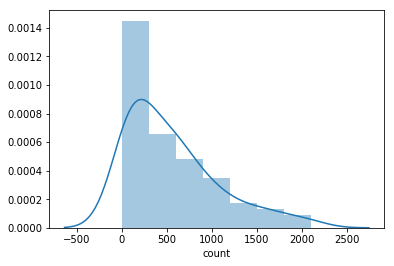

In [36]:
%matplotlib inline
#get the average number of tweets for those who tweeted in 2018
count_dist = tweets_2018.groupby('handle')['text'].count().reset_index(name='count')
sns.distplot(count_dist['count'])
print('Median Tweets for Candidates: ', count_dist['count'].median())

Median Tweets for Candidates:  3125.0


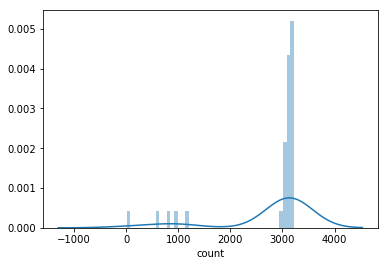

In [37]:
#tweets for those not retrieved from 2018
count_dist = not_2018.groupby('handle')['text'].count().reset_index(name='count')
sns.distplot(count_dist['count'])
print('Median Tweets for Candidates: ', count_dist['count'].median())

In [41]:
#For those that did not have tweets in 2018, grab the first 450 tweets
not_2018_ordered = not_2018.groupby(["handle"]).apply(lambda x: x.sort_values(["created_at"], ascending = True)).reset_index(drop=True)

#grab the top 450 from everyone
final_not_2018 = not_2018_ordered.groupby('handle').head(450)

In [42]:
final_not_2018.head()

,handle,user_name,candidate_2020,join_2020,candidate_2016,join_2016,text,created_at
0,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,RT @AndrewYang: This is the simulation where w...,2020-01-25 23:58:22
1,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,What I love about Iowa and New Hampshire is th...,2020-01-26 01:05:31
2,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,RT @IowaForYang: We are seeing record levels o...,2020-01-26 02:59:46
3,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,RT @Evan_Low: Ok i admit it.. i’m having a ton...,2020-01-26 03:00:10
4,AndrewYang,Andrew Yang,True,2017-11-06,False,NaN,RT @EliseBritton3: Proud to be a NH CD1 Delega...,2020-01-26 03:03:38


In [77]:
#merge the dataframes and convert the target variable
merge_df = pd.concat([final_not_2018, tweets_2018], axis=0, sort=False)
print(merge_df.shape)

final_df = merge_df.groupby('handle').agg({'text':'sum', 'candidate_2020':'first'}).reset_index()

final_df['candidate_2020'] = final_df['candidate_2020'].apply(lambda x: 1 if x is True else 0)
print("Final Dataframe shape: ", final_df.shape)

(56452, 8)
Final Dataframe shape:  (109, 3)


In [59]:
final_df.head()

,handle,text,candidate_2020
0,AndrewYang,RT @AndrewYang: This is the simulation where w...,1
1,BenMcAdams,@20SidedGeis @GOP Agree. Not ‘both siding’ the...,0
2,BernieSanders,This is a time to take on powerful special int...,1
3,BetoORourke,All eyes on you McAllen! I’ve always been stru...,1
4,BilldeBlasio,RT @AndrewGillum: We are going to keep fightin...,1


In [63]:
MyVect5=CountVectorizer(analyzer = 'word',
                        stop_words='english',
                        #token_pattern='(?u)[a-zA-Z]+',
                        #token_pattern=pattern,
                        #tokenizer=LemmaTokenizer(),
                        #strip_accents = 'unicode', 
                        lowercase = True
                        )

In [64]:
#slightly modified our homework code for the vectorizer. Might want to think about removing numeric columns
FinalDF = pd.DataFrame()
X5 = MyVect5.fit_transform(final_df.text)
ColumnNames2=MyVect5.get_feature_names()
builder=pd.DataFrame(X5.toarray(),columns=ColumnNames2)
builder["Label"]=final_df['candidate_2020']
FinalDF = FinalDF.append(builder)

In [ ]:
FinalDF.head()

In [67]:
#train/test split
data_train, data_test = train_test_split(FinalDF, test_size=0.3)

In [68]:
data_train_input=data_train.drop(["Label"], axis=1)

labels_train=data_train["Label"]

data_test_input = data_test.drop(["Label"], axis=1)

label_test=data_test["Label"]

In [76]:
MyModelNB= MultinomialNB()

MyModelNB.fit(data_train_input, labels_train)

Prediction = MyModelNB.predict(data_test_input)


print("\nThe prediction from NB is:")
print(Prediction)
print("\nThe actual labels are:")
print(label_test)

cnf_matrix = confusion_matrix(label_test, Prediction)
print("\nThe confusion matrix is:")
print(cnf_matrix)

print(classification_report(label_test, Prediction))


The prediction from NB is:
[0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0]

The actual labels are:
89     1
74     0
51     0
3      1
85     0
64     0
78     0
80     0
13     1
73     0
42     0
16     0
28     1
94     1
99     0
103    1
48     0
96     0
102    0
106    1
87     0
54     0
5      0
29     0
60     0
17     0
49     1
21     0
33     0
88     1
41     0
12     0
52     1
Name: Label, dtype: int64

The confusion matrix is:
[[18  5]
 [ 3  7]]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       0.58      0.70      0.64        10

    accuracy                           0.76        33
   macro avg       0.72      0.74      0.73        33
weighted avg       0.77      0.76      0.76        33

